In [707]:
import os
import numpy as np
from numpy import ma
import pandas as pd
import pykalman as pyk
import matplotlib.pyplot as plt
from scipy import linalg
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import lfilter
import scipy.optimize as opt

In [247]:
os.chdir('/Users/johncook/Desktop/Data Science/Time Series/Homework/')

In [344]:
F=open('data6_2.txt','r')
l1=F.read().split('\n')
data=np.array(list(map(float,l1[:-1])))

In [667]:
def KalmanFilter2(Nsamples=Nsamples,Phi=Phi,P=P,Q=Q,R=R,A=A,Xk_prev=Xk_prev):
    Xk_buffer = np.zeros([1,Nsamples])
    Errors=np.zeros([1,Nsamples])
    Covariances=np.zeros([1,Nsamples])
    Xk_buffer[:,0]=Xk_prev
    Z_buffer = np.zeros([1,Nsamples])[0]
    for k in range(0,Nsamples-1):
        Z=data[k+1]
        Z_buffer[k+1] = Z
        #Kalman iteration
        P1 = np.dot(np.dot(Phi,P),Phi.T) + Q

        S = np.dot(np.dot(A,P1),A) + R

        #Kalman Gain, this is the weight given to the measurement
        K = np.dot(P1,A)*(1/S)

        P = P1 - np.dot(np.dot(K,A),P1)
        #print(P)
        Xk = np.dot(Phi,Xk_prev) + K*(Z-np.dot(np.dot(A,Phi),Xk_prev))
        #print(Xk)
        Xk_buffer[:,k+1]=Xk

        #Set up next iteration
        Xk_prev = Xk
    return A*Xk_buffer

In [648]:
def KalmanFilter(Nsamples=Nsamples,Phi=Phi,P=P,Q=Q,R=R,A=A,Xk_prev=Xk_prev):
    Xk_buffer = np.zeros([1,Nsamples])
    Errors=np.zeros([1,Nsamples])
    Covariances=np.zeros([1,Nsamples])
    Xk_buffer[:,0]=Xk_prev
    Z_buffer = np.zeros([1,Nsamples])[0]
    for k in range(0,Nsamples-1):
        Errors[:,k]=data[k]-A*Xk_prev
        Covariances[:,k]=A*P*A + R
        Z=data[k+1]
        Z_buffer[k+1] = Z
        #Kalman iteration
        P1 = np.dot(np.dot(Phi,P),Phi.T) + Q

        S = np.dot(np.dot(A,P1),A) + R

        #Kalman Gain, this is the weight given to the measurement
        K = np.dot(P1,A)*(1/S)

        P = P1 - np.dot(np.dot(K,A),P1)
        #print(P)
        Xk = np.dot(Phi,Xk_prev) + K*(Z-np.dot(np.dot(A,Phi),Xk_prev))
        #print(Xk)
        Xk_buffer[:,k+1]=Xk

        #Set up next iteration
        Xk_prev = Xk
    Errors[:,Nsamples-1]=data[Nsamples-1]-A*Xk_prev
    Covariances[:,Nsamples-1]=A*P*A + R
    return Errors[0],Covariances[0]

In [732]:
FullErrors=[]
NegLLs=[]
def KFNegLL(Params):
    Errors,Covariances=KalmanFilter(Phi=Params[0],A=Params[1],Q=Params[2],R=Params[3])
    #print(Errors,Covariances)
    NegLL=(.5*sum(np.array(list(map(np.log10,Covariances)))))+(.5*sum(np.array(list(map(np.square,Errors)))*np.array(list(map(lambda x: 1/x,Covariances)))))
    FullErrors.append(pd.Series(Errors))
    NegLLs.append(NegLL)
    return NegLL

In [733]:
#Initialize Parameters
Nsamples=len(data)
Xk_prev = np.array([0])
Xk=[]
Phi=.4
sigma_model=1
P=np.array([sigma_model**2])
Q=1
sigma_meas = 1
R=.8
A=.3
InitParams=[Phi,A,Q,R]

In [741]:
def OptimizeMethod(meth):
    Nsamples=len(data)
    Xk_prev = np.array([0])
    Xk=[]
    Phi=.4
    sigma_model=1
    P=np.array([sigma_model**2])
    Q=.1
    sigma_meas = 1
    R=.1
    A=.3
    InitParams=[Phi,A,Q,R]
    est=opt.minimize(KFNegLL,InitParams,method=meth)
    print("Phi: "+str(est.x[0]))
    print("A: "+str(est.x[1]))
    print("Q: "+str(est.x[2]))
    print("R: "+str(est.x[3]))
    print("Number of Iterations:")
    print(len(FullErrors))
    print("First Plot: Errors at iteration 0(Blue),5(Green),10(Red),20(Teal),"+str(len(FullErrors))+"(Purple)")
    FullErrors[0].plot()
    FullErrors[5].plot()
    FullErrors[10].plot()
    FullErrors[20].plot()
    FullErrors[len(FullErrors)-1].plot()
    plt.figure()
    Results=KalmanFilter2(Phi=est.x[0],A=est.x[1],Q=est.x[2],R=est.x[3],Xk_prev=Xk_prev)
    print("Second Plot: Kalman Filter run with final model parameters")
    pd.Series(data).plot()
    pd.Series(Results[0]).plot()

Phi: 1.39749800966
A: 5.83404152091
Q: 1.15066571121
R: 0.688499224574
Number of Iterations:
2128
First Plot: Errors at iteration 0(Blue),5(Green),10(Red),20(Teal),2128(Purple)
Second Plot: Kalman Filter run with final model parameters


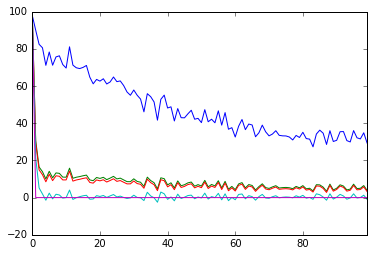

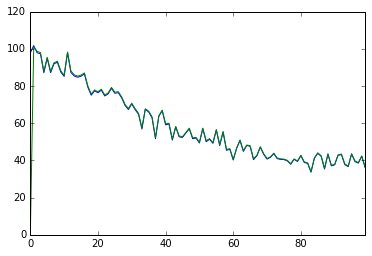

In [742]:
OptimizeMethod('L-BFGS-B')

Phi: 123.435037489
A: 366.419021945
Q: 518.272625765
R: 897.260061693
Number of Iterations:
18013
First Plot: Errors at iteration 0(Blue),5(Green),10(Red),20(Teal),18013(Purple)
Second Plot: Kalman Filter run with final model parameters


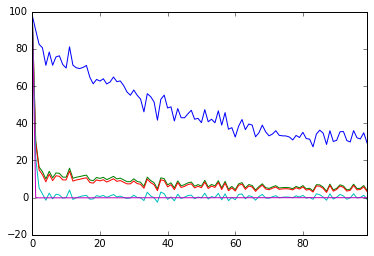

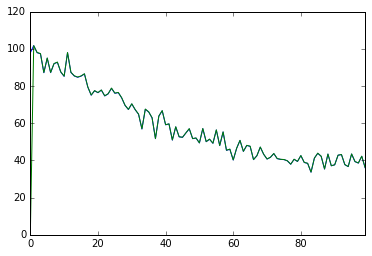

In [757]:
OptimizeMethod('BFGS')

Phi: 8.97264616029
A: 23.0235315771
Q: 4.93477593121
R: 1.82371347906e-14
Number of Iterations:
17726
First Plot: Errors at iteration 0(Blue),5(Green),10(Red),20(Teal),17726(Purple)
Second Plot: Kalman Filter run with final model parameters


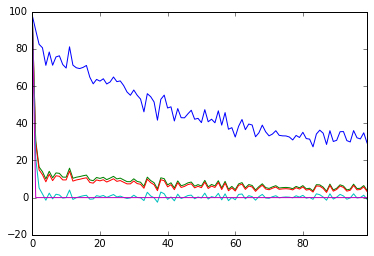

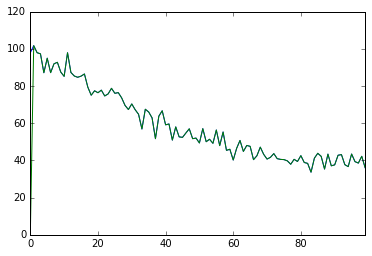

In [756]:
OptimizeMethod('Nelder-Mead')

Phi: 97.2309927886
A: 557.499389193
Q: 577.980898219
R: -899.338422493
Number of Iterations:
24936
First Plot: Errors at iteration 0(Blue),5(Green),10(Red),20(Teal),24936(Purple)
Second Plot: Kalman Filter run with final model parameters


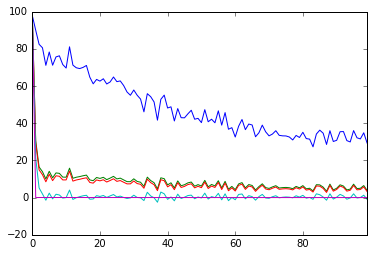

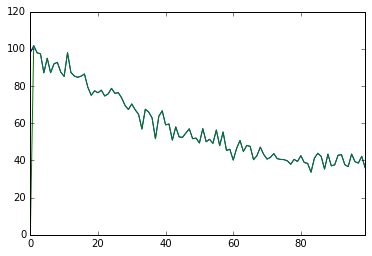

In [758]:
OptimizeMethod('CG')

# Analysis

I created a new function which used the kalman filter function I produced for the previous assignment(slightly modified), and then calculated the negative log likelihood using the time series of errors and covariances. I then created a function to easily test different optimization methods. While the final parameters fit the given data now hese optimization methods gave very different results. Both the L-BFGS-B and Nelder-Mead methods returned believable results. BFGS and Conjugate Gradient did not return believable results. It seems that we will see very large numbers of Phi and A when the values for Q and R are so high. I believe that the high estimated Q and R may have something to do with the non-stationary nature of the time series.